In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fem import install

install()

# **Lab 11 - Metodo agli Elementi Finiti (stazionario) - Parte 2**

## Condizioni di Neumann

Per problemi mono-dimensionali, definiti su un certo intervallo $[a,b]\subset\mathbb{R}$, una condizione al bordo della forma</br></br>
$$u'(b)=\gamma,$$
</br>
o, in alternativa, $u'(a)=\gamma$, è detta condizione di Neumann. Nei metodi agli elementi finiti, questo tipo di condizione viene tipicamente gestita includendo esplicitamente un termine di bordo nella formulazione variazionale. Ad esempio, si consideri il seguente problema con condizioni miste Dirichlet-Neumann,

$$\begin{cases}
-u'' = f & \text{in}\;(a,b)\\\\
u(a)=\alpha,\;\;
u'(b)=\gamma.
\end{cases}$$
</br>
Posto $V_{\text{test}}:=\{v\in H^{1}(a,b)\;|\;v(a)=0\}$, la sua formulazione debole è
</br></br>
$$\int_a^b-u''vdx = \int_a^b fvdx \quad\quad \forall v\in V_{\text{test}}\quad\rightsquigarrow\quad\int_a^bu'v'dx - \left[u'v\right]\Big |^{b}_{a}= \int_a^b fvdx \quad\quad \forall v\in V_{\text{test}}$$
</br>
$$\rightsquigarrow\int_a^bu'v'dx = \int_a^b fvdx + \left[u'v\right]\Big |^{b}_{a}\quad\quad \forall v\in V_{\text{test}}$$
</br>
$$\rightsquigarrow\int_a^bu'v'dx = \int_a^b fvdx + \gamma v(b)\quad\quad \forall v\in V_{\text{test}}.$$

La precedente si può riscrivere con un piccolo trucco di notazione. In generale, data una funzione $g:[a,b]\to\mathbb{R}$, possiamo scrivere
$$\int_{\{a,b\}}gds:=g(a)+g(b),$$
introducendo il cosìdetto *integrale di bordo*, che è definito sull'insieme degli estremi $\{a,b\}$ (integrale 0-dimensionale). Con questo escamotage, la formulazione debole del problema diventa
</br></br>
$$\rightsquigarrow\int_a^bu'v'dx = \int_a^b fvdx + \int_{\{a,b\}}(u'\cdot n) vds\quad\quad \forall v\in V_{\text{test}},$$

dove $n:=\{a,b\}\to\{-1,1\}$ è la *normale esterna*, definita di modo che $n(a)=-1$ ed $n(b)=-1$. In particolare, se definiamo una qualsiasi $\phi:[a,b]\to\mathbb{R}$ tale che

$$\phi(a):=0\quad\text{e}\quad\phi(b):=\gamma,$$

allora, la formulazione debole del problema diventa
</br></br>
$$\rightsquigarrow\int_a^bu'v'dx = \int_a^b fvdx + \int_{\{a,b\}}\phi vds\quad\quad \forall v\in V_{\text{test}},$$

A livello di implementazione, ciò significa, semplicemente, che dobbiamo includere il termine aggiuntivo $\int_{\{a,b\}}\phi vds$ durante l'assemblaggio del termine noto $\mathbf{F}$.
</br>
</br>
</br>
**NOTA BENE**: se le condizioni al bordo vengono invertite, cioè abbiamo Dirichlet a destra, $x=b$, e Neumann a sinistra $x=a$, dovremo definire $\phi$ di modo che $\phi(b)=0$ e $\phi(a)=-\gamma$. **Infatti**, $\phi$ coincide con $u'$ a meno segno, il quale è determinato dalla direzione della normale esterna (vettore **uscente** dall'intervallo).





<mark>**Esercizio 1.1**</mark></br>

Sia $[a,b]\subset\mathbb{R}$ e sia $\gamma\in\mathbb{R}$. Fornire la rappresentazione analitica di due funzioni, $\phi_{\text{left}}$ e $\phi_{\text{right}}$ tali che
</br></br>
$$\phi_{\text{left}}(a)=-\gamma,\quad\phi_{\text{left}}(b)=0,$$
</br>
$$\phi_{\text{right}}(a)=0,\quad\phi_{\text{right}}(b)=\gamma,$$

**Soluzione**. Entrambe le funzioni si possono definire usando delle generiche mappe costanti a tratti. In alternativa, si possono usare anche le seguenti varianti continue:

$$\phi_{\text{left}}(x)=\gamma(x-b)/(b-a),\quad\quad\phi_{\text{right}}(x)=\gamma(x-a)/(b-a)$$

<mark>**Esercizio 1.2**</mark></br>

Si consideri il seguente problema differenziale

$$\begin{cases}
-u''=30x & x\in(0,1)\\
u(0)=0\\u'(1)=3.
\end{cases}$$

Risolvere il problema implementando il metodo agli elementi finiti (grado polinomiale $r=1$, passo della mesh $h=0.1$). Confrontare graficamente la soluzione ottenuta con la soluzione esatta, $u(x)=18x-5x^3.$

In [2]:
from fem import Line, generate_mesh, FEspace, plot
domain = Line(0, 1)
mesh = generate_mesh(domain, stepsize = 0.1)
V = FEspace(mesh, 1)


from fem import interpolate
f = lambda x: 30*x
fh = interpolate(f, V)

phi = lambda x: 3*x
phih = interpolate(phi, V)


from fem import dx, ds, deriv, assemble
def l(v):
  return fh*v*dx + phih*v*ds

def a(u, v):
  return deriv(u)*deriv(v)*dx

A = assemble(a, V)
F = assemble(l, V)

from fem import DirichletBC, applyBCs
def isLeftNode(x):
  return x < 1e-12

dbc = DirichletBC(isLeftNode, 0.0)
A = applyBCs(A, V, dbc)
F = applyBCs(F, V, dbc)

from scipy.sparse.linalg import spsolve
u = spsolve(A, F)

from fem import dof2fun
u = dof2fun(u, V)

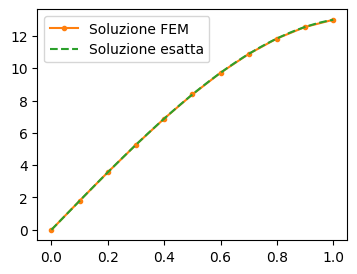

In [3]:
import matplotlib.pyplot as plt
uex = lambda x: 18*x - 5*(x**3)
xplot = np.linspace(0, 1, 1000)

plt.figure(figsize = (4, 3))
plot(u, label = 'Soluzione FEM', marker = '.')
plt.plot(xplot, uex(xplot), '--', label = 'Soluzione esatta')
plt.legend()
plt.show()

<mark>**Esercizio 1.3**</mark></br>

Ripetere l'Es. 1.2 invertendo le condizioni di Neumann e Dirichlet, cioè risolvendo

$$\begin{cases}
-u''=30x & x\in(0,1)\\
u'(0)=3\\u(1)=0,
\end{cases}$$

la cui soluzione esatta è $u(x)=3x-5x^3+2.$

In [4]:
domain = Line(0, 1)
mesh = generate_mesh(domain, stepsize = 0.1)
V = FEspace(mesh, 1)

f = lambda x: 30*x
fh = interpolate(f, V)

phi = lambda x: 3*(x-1)
phih = interpolate(phi, V)

def l(v):
  return fh*v*dx + phih*v*ds

def a(u, v):
  return deriv(u)*deriv(v)*dx

A = assemble(a, V)
F = assemble(l, V)

def isRightNode(x):
  return x > 1 - 1e-12

dbc = DirichletBC(isRightNode, 0.0)
A = applyBCs(A, V, dbc)
F = applyBCs(F, V, dbc)

u = spsolve(A, F)
u = dof2fun(u, V)

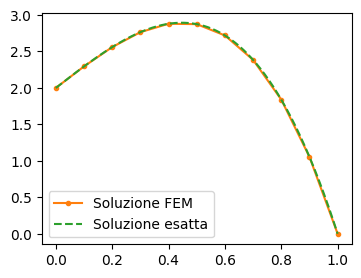

In [5]:
import matplotlib.pyplot as plt
uex = lambda x: 3*x - 5*(x**3) + 2
xplot = np.linspace(0, 1, 1000)

plt.figure(figsize = (4, 3))
plot(u, label = 'Soluzione FEM', marker = '.')
plt.plot(xplot, uex(xplot), '--', label = 'Soluzione esatta')
plt.legend()
plt.show()

# Equazioni di diffusione-trasporto-reazione

Si consideri il seguente problema differenziale, descrivente un fenomeno di diffusione-trasporto-reazione (stazionario)

$$
\begin{cases}
-au''+bu'+cu = f & x\in(0,1)\\
u(0)=u(1)=0.
\end{cases}
$$

dove $a>0,b\neq0,c>0$ sono opportuni coefficienti. La corrispondente formulazione debole è
</br></br>
$$a\int_0^1u'v'dx+b\int_0^1u'vdx+c\int_0^1uvdx=\int_0^1fvdx.$$

<mark>**Esercizio 2.1**</mark></br>

Sia $V_h$ lo spazio elementi finiti di grado $r=1$ e passo $h=0.01$. Assemblare le matrici associate alle forme bilineari</br></br>
$$a_{\text{diff}}(u,v):=\int u'v'dx,\quad\quad
a_{\text{trasp}}(u,v):=\int u'vdx,\quad\quad
a_{\text{reac}}(u,v):=\int uvdx,$$
</br>
(quindi, senza imporre alcuna condizione al bordo). Sono tutte matrici simmetriche? Se la risposta è negativa: quali non lo sono?

In [6]:
domain = Line(0, 1)
mesh = generate_mesh(domain, stepsize = 0.01)
V = FEspace(mesh, 1)

a_diff = lambda u, v: deriv(u)*deriv(v)*dx
a_trasp = lambda u, v: deriv(u)*v*dx
a_reac = lambda u, v: u*v*dx

A_diff = assemble(a_diff, V)
A_trasp = assemble(a_trasp, V)
A_reac = assemble(a_reac, V)

import numpy as np
np.max(np.abs(A_diff-A_diff.T)), np.max(np.abs(A_trasp-A_trasp.T)), np.max(np.abs(A_reac-A_reac.T))

(0.0, 1.0, 0.0)

<mark>**Esercizio 2.2**</mark></br>

Sfruttando le matrici già assemblate all'Es. 2.1, risolvere numericamente l'equazione di diffusione-trasporto-reazione per $a=1$, $b=2$ e $c=3$. Si ponga $f\equiv-1$. Confrontare la soluzione ottenuta con quella esatta, sapendo che quest'ultima è della forma

$$u(x)=C_1 e^{-x}+C_2e^{3x}-\frac{1}{3},$$

dove $C_2=\frac{1}{3}\frac{e-1}{e^4-1}$ e $C_1=\frac{1}{3}-C_2$.

In [7]:
fh = interpolate(-1.0, V)
l = lambda v: fh*v*dx
F = assemble(l, V)

a, b, c = 1, 2, 3
A = a*A_diff + b*A_trasp + c*A_reac

def isLeftorRight(x):
  return True

dbc = DirichletBC(isLeftorRight, 0.0)
A = applyBCs(A, V, dbc)
F = applyBCs(F, V, dbc)

u = spsolve(A, F)
u = dof2fun(u, V)

In [8]:
e = np.exp(1)
c2 = (e-1.0)/(e**4-1.0)/3.0
c1 = 1.0/3.0 - c2
uex = lambda x: c1*np.exp(-x) + c2*np.exp(3*x) - 1.0/3.0

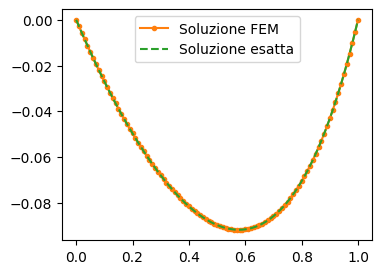

In [9]:
xplot = np.linspace(0, 1, 1000)

plt.figure(figsize = (4, 3))
plot(u, label = 'Soluzione FEM', marker = '.')
plt.plot(xplot, uex(xplot), '--', label = 'Soluzione esatta')
plt.legend()
plt.show()

<mark>**Esercizio 2.3**</mark></br>

Provate a ripetere l'Es. 2.2 per diversi valori di $b>0$. Come cambia la soluzione numerica?

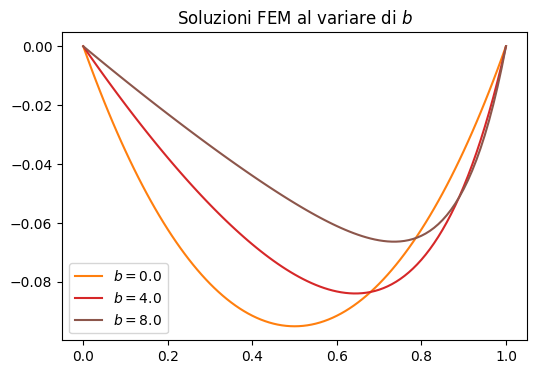

In [10]:
def solve_for_b(b):
  fh = interpolate(-1.0, V)
  l = lambda v: fh*v*dx
  F = assemble(l, V)

  a, c = 1, 3
  A = a*A_diff + b*A_trasp + c*A_reac

  def isLeftorRight(x):
    return True

  dbc = DirichletBC(isLeftorRight, 0.0)
  A = applyBCs(A, V, dbc)
  F = applyBCs(F, V, dbc)

  u = spsolve(A, F)
  return dof2fun(u, V)


plt.figure(figsize = (6, 4))
for b in [0, 4, 8]:
  u = solve_for_b(b)
  plot(u, label = '$b=%.1f$' % b)
plt.title("Soluzioni FEM al variare di $b$")
plt.legend()
plt.show()